In [12]:
# Example of calculations and plotting for Barten Crieria with Gamma or PQ
# functions.
#
# Example and plot originally produced by Tucker Downs, September 2023.

from dataclasses import dataclass

import colour
import numpy as np
from colour.contrast import barten1999
from colour.hints import ArrayLike, NDArrayFloat
from colour.models.rgb.transfer_functions import st_2084
from colour.utilities import as_float, as_float_array
from matplotlib import pyplot as plt
from scipy.optimize import fmin

plt.rcParams["font.size"] = 8
plt.rcParams["legend.fontsize"] = 8

In [13]:

settings_BT2246 = {
    "k": 3.0,
    "T": 0.1,
    "X_max": 12,
    "N_max": 15,
    "n": 0.03,
    "p": 1.2274 * 10**6,
    "phi_0": 3 * 10**-8,
    "u_0": 7,
}


def maximise_spatial_frequency(L: ArrayLike) -> NDArrayFloat:
    """
    Maximise the spatial frequency :math:`u` for given luminance value.

    Parameters
    ----------
    L
        Luminance value at which to maximize the spatial frequency :math:`u`.

    Returns
    -------
    :class:`np.float` or :class:`numpy.ndarray`
        Maximised spatial frequency :math:`u`.
    """

    L = as_float_array(L)

    maximised_spatial_frequency = []
    X_0 = 60
    for L_v in L:
        d = colour.contrast.pupil_diameter_Barten1999(L_v, X_0)
        sigma = colour.contrast.sigma_Barten1999(0.5 / 60, 0.08 / 60, d)
        E = colour.contrast.retinal_illuminance_Barten1999(L_v, d, True)
        maximised_spatial_frequency.append(
            fmin(
                lambda x: (
                    -colour.contrast.contrast_sensitivity_function_Barten1999(
                        u=x,
                        sigma=sigma,  # noqa: B023
                        X_0=X_0,
                        E=E,  # noqa: B023
                        **settings_BT2246,
                    )
                ),
                0,
                disp=False,
            )[0]
        )

    return as_float(maximised_spatial_frequency)


luminance_samples = np.logspace(np.log10(0.0001), np.log10(10000), 1000)

X_0 = Y_0 = 60
d = barten1999.pupil_diameter_Barten1999(luminance_samples, X_0, Y_0)
sigma = barten1999.sigma_Barten1999(0.5 / 60, 0.08 / 60, d)
E = barten1999.retinal_illuminance_Barten1999(luminance_samples, d)
frequency_of_peak_sensitivity = maximise_spatial_frequency(luminance_samples)

peak_sensitivity = colour.contrast.contrast_sensitivity_function_Barten1999(
    u=frequency_of_peak_sensitivity,
    sigma=sigma,
    E=E,
    X_0=X_0,
    Y_0=Y_0,
    **settings_BT2246,
)


def sensitivity_to_min_contrast(sensitivity):
    sensitivity = as_float_array(sensitivity)
    return 100 * (1 / sensitivity) * 2 * (np.pi / 4)


def min_contrast_to_sensitivity(contrast):
    contrast = as_float_array(contrast)
    return 1 / ((contrast / 100) / (2 * np.pi / 4))

In [14]:
def plot_PQ_line(ax, bit_depth, **kwargs):
        PQ_values = np.arange(1, 2**bit_depth - 2)
        PQ0 = st_2084.eotf_ST2084((PQ_values - 0) / (2**bit_depth - 1))
        PQ1 = st_2084.eotf_ST2084((PQ_values + 1) / (2**bit_depth - 1))
        PQ_contrast = 100 * abs(PQ0 - PQ1) / PQ0

        return ax.plot(PQ0, PQ_contrast, **kwargs)

@dataclass
class GammaOptions:
    max_nits: float = 100
    power: float = 2.2
    bits: int = 8

def plot_gamma_line(ax, options: GammaOptions, **kwargs):
    values = np.arange(1, 2**options.bits - 2)
    max_value = 2**options.bits - 1

    gamma_nits_0 = ((values + 0) / max_value) ** options.power * options.max_nits
    gamma_nits_1 = ((values + 1) / max_value) ** options.power * options.max_nits
    gamma_contrast = (
        100 * abs(gamma_nits_0 - gamma_nits_1) / gamma_nits_0
    )

    return ax.plot(gamma_nits_0, gamma_contrast, label=rf"{options.bits:.0f} bit, $\gamma$={options.power:.2f}, {options.max_nits:.0f} nits",**kwargs)

In [15]:
def setup_plot():
    fig = plt.figure("Barten Plots")
    fig.clear()
    fig.set_dpi(3840 / 12)

    fig.set_layout_engine("tight")
    fig.set_size_inches(8, 4.5)

    ax = fig.subplots(1, 1)

    ax.set_ylabel("Minimum Detectable Contrast (%)")

    ax.set_xscale("log")
    ax.set_xlim(0.0001, 10000)
    ax.set_xlabel("Luminance (cd/m$^2$)")
    ax.set_xticks(
        10.0 ** np.arange(-4, 5),
        labels=[f"{10.0**m:g}" for m in np.arange(-4, 5)],
        rotation=55,
    )

    ax.set_yscale("log")
    ax.set_ylim(0.09, 25)

    ax.set_yticks([0.1, 1, 10], labels=[".1", "1", "10"])

    ax.grid(visible=True, which="major", axis="both")
    ax.grid(visible=True, which="minor", axis="both", alpha=0.15)

    return fig, ax

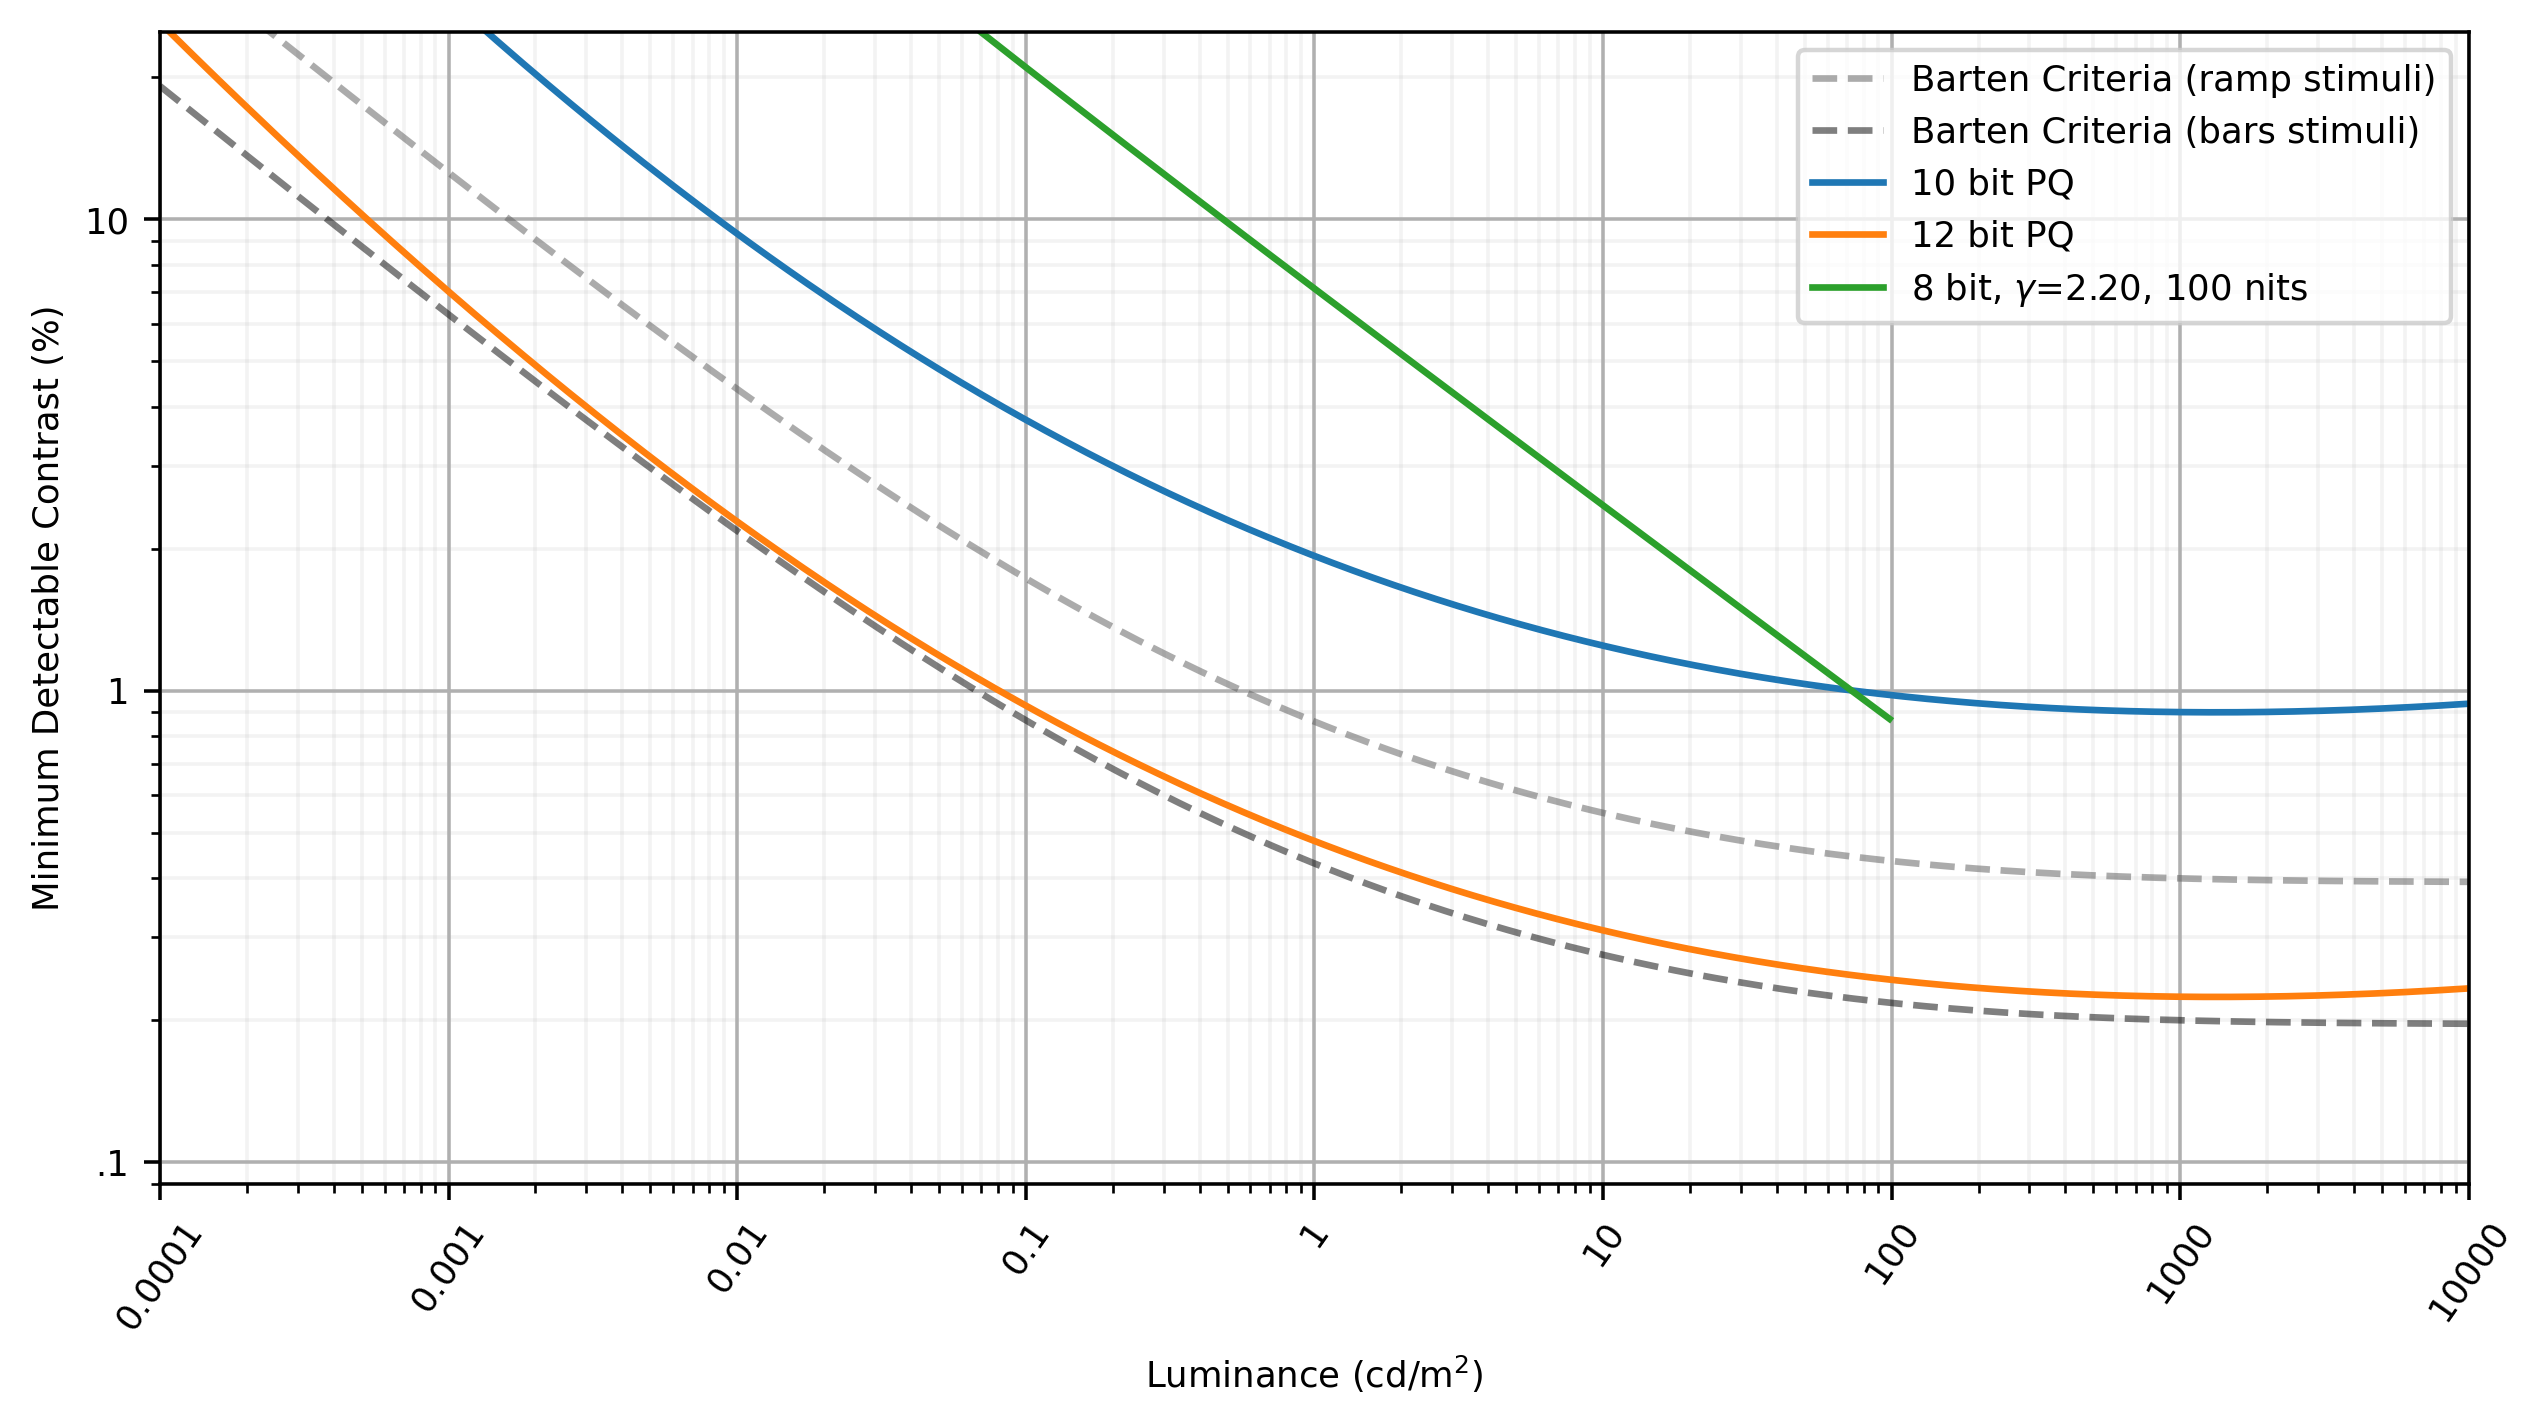

In [16]:
fig, ax = setup_plot()

detectable_contrast_square = sensitivity_to_min_contrast(peak_sensitivity)
detectable_contrast_ramp = detectable_contrast_square * 2

ax.plot(
    luminance_samples,
    detectable_contrast_ramp,
    linestyle="--",
    color=(0.35, 0.35, 0.35, 0.5),
    label="Barten Criteria (ramp stimuli)",
)
barten_line = ax.plot(
    luminance_samples,
    detectable_contrast_square,
    linestyle="--",
    color=(0, 0, 0, 0.5),
    label="Barten Criteria (bars stimuli)",
)[0]
plot_PQ_line(ax, 10, label="10 bit PQ")
plot_PQ_line(ax, 12, label="12 bit PQ")

opt = GammaOptions(max_nits=100, bits=8,power=2.2)

gamma_line = plot_gamma_line(
    ax,
    options=opt
)[0]

ax.legend(loc="upper right")